## 5. Data Scientist - Continued

In [203]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [204]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.appName('Spark - Data Scientist Demo') \
.config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest.jar') \
.config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.18.0") \
.getOrCreate()

In [205]:
spark.conf.get("spark.app.id")
spark.sparkContext._jvm.scala.util.Properties.versionString()

'version 2.12.12'

#### Refactor Table - add a date (day) field
Transform the step-column [1,742] to days [1,31]


In [229]:
project_id = !gcloud config list --format 'value(core.project)' 2>/dev/null
bq_enriched_dataset_name = project_id[0] + '-enriched'
bq_enriched_dataset_name = bq_enriched_dataset_name.replace('-', '_')
bq_enriched_table_path = project_id[0] + ':' + bq_enriched_dataset_name + '.transaction_analysis_enriched' 
bq_enriched_table_path

'datalake-vol2:datalake_vol2_enriched.transaction_analysis_enriched'

In [230]:
data = spark.read \
.format("bigquery") \
.option("table", bq_enriched_table_path) \
.load()

Py4JJavaError: An error occurred while calling o21639.load.
: java.lang.RuntimeException: Table datalake-vol2.datalake_vol2_enriched.transaction_analysis_enriched not found
	at scala.sys.package$.error(package.scala:30)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.$anonfun$createRelationInternal$1(BigQueryRelationProvider.scala:76)
	at scala.Option.getOrElse(Option.scala:189)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.createRelationInternal(BigQueryRelationProvider.scala:76)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.createRelation(BigQueryRelationProvider.scala:45)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:345)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:297)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:286)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:286)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:221)
	at sun.reflect.GeneratedMethodAccessor244.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [208]:
data = data.drop('type_OHE','features','rawPrediction','probability')
data.cache()

DataFrame[transactionID: string, step: bigint, type: string, amount: double, oldbalanceOrg: double, newbalanceOrig: double, oldbalanceDest: double, newbalanceDest: double, isFraud: bigint, type_Index: double, prediction: double, nameOrig: string, nameDest: string]

In [209]:
data.show(5)

+--------------------+----+-----+--------+-------------+--------------+--------------+--------------+-------+----------+----------+-----------+-----------+
|       transactionID|step| type|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|type_Index|prediction|   nameOrig|   nameDest|
+--------------------+----+-----+--------+-------------+--------------+--------------+--------------+-------+----------+----------+-----------+-----------+
|015f0179-4648-4f8...| 191|DEBIT| 3954.62|        833.0|           0.0|     824448.22|     828402.84|      0|       4.0|       0.0|C2035400985| C939746540|
|04cf39f9-dcae-493...|  47|DEBIT|12150.18|      10456.0|           0.0|     4769502.9|    4781653.08|      0|       4.0|       0.0|C1186506550|C1951056653|
|1094a938-c1c8-4cd...|  35|DEBIT|  4871.9|        124.0|           0.0| 1.037547962E7| 1.038035152E7|      0|       4.0|       0.0| C101724235| C552268766|
|1e8bff39-6fa2-49e...|  11|DEBIT| 6360.21|        239.0|        

In [210]:
pandas_df = data.toPandas()

**TODO** (Challenge 3)
* Convert the column steps into days
* Each step corresponds to one hour. The dataset was created over the span of a month. There are 742 steps which should be converted to 31 days

In [211]:
pandas_df['days'] = <enter-code-here>

In [212]:
#Check if there are all days - this should output day 1 to 31
sorted(pd.unique(pandas_df['days']).tolist())

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0]

In [213]:
pandas_df['days'] = pandas_df['days'].astype(int)

In [214]:
pandas_df

,transactionID,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_Index,prediction,nameOrig,nameDest,days
0,015f0179-4648-4f81-b991-ea89d20eae11,191,DEBIT,3954.62,833.0,0.0,824448.22,828402.84,0,4.0,0.0,C2035400985,C939746540,8
1,04cf39f9-dcae-4930-bd81-02bda8dffee2,47,DEBIT,12150.18,10456.0,0.0,4769502.90,4781653.08,0,4.0,0.0,C1186506550,C1951056653,2
2,1094a938-c1c8-4cd3-b692-30e6af51a03c,35,DEBIT,4871.90,124.0,0.0,10375479.62,10380351.52,0,4.0,0.0,C101724235,C552268766,2
3,1e8bff39-6fa2-49ec-aeb0-aaf6695ff403,11,DEBIT,6360.21,239.0,0.0,850823.67,885014.20,0,4.0,0.0,C1042069153,C360382401,1
4,2c3ef66a-ec69-4eba-b855-f5b289a738d5,404,DEBIT,5731.01,484.0,0.0,59809.89,65540.90,0,4.0,0.0,C1630040166,C689400888,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271923,fff83379-2a33-4234-b079-cf4d225cbbce,137,TRANSFER,451318.17,0.0,0.0,6013046.02,6464364.18,0,3.0,0.0,C2023385800,C496695089,6
1271924,fff91d90-d826-4868-be1c-b64cdf5c3d63,16,TRANSFER,294535.14,0.0,0.0,306150.60,1075171.12,0,3.0,0.0,C1408595409,C890805757,1
1271925,fff99c9f-6369-4e79-95cd-6819a14712a1,371,TRANSFER,559782.15,0.0,0.0,679670.40,1239452.55,0,3.0,0.0,C1330538810,C399178707,16
1271926,fffa690f-bb70-4dc1-b521-4033ce30bf72,38,TRANSFER,1047958.39,0.0,0.0,2819248.59,3867206.98,0,3.0,0.0,C197637158,C2039186472,2


#### Do some further analyis including visualization

Text(0, 0.5, 'Frequency')

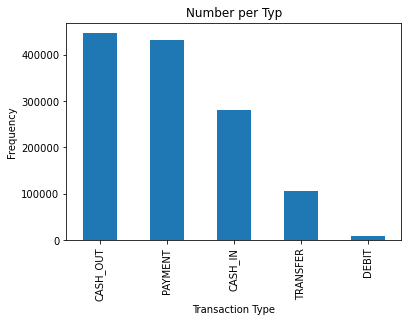

In [215]:
ax = pandas_df['type'].value_counts().plot(kind='bar',title="Number per Typ")
ax.set_xlabel("Transaction Type")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

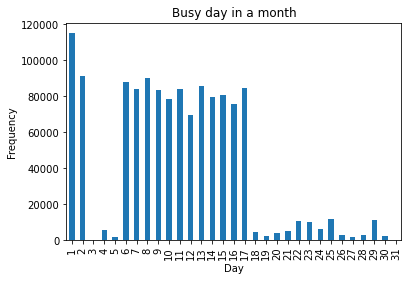

In [216]:
ax = pandas_df['days'].value_counts().plot(kind='bar',title="Busy day in a month")
ax.set_xlabel("Day")
ax.set_ylabel("Frequency")

<AxesSubplot:ylabel='amount'>

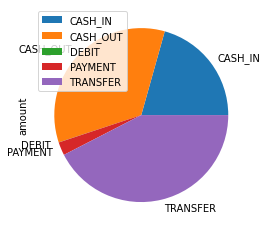

In [217]:
pandas_df.groupby(['type']).sum().plot(kind='pie', y='amount')

#### Store table in a performance opimized way

In [ ]:
df = spark.createDataFrame(pandas_df)

In [219]:
bq_optimized_table_name = 'transaction_data_optimized'
bq_optimized_table_path=  project_id[0] +  '_enriched.' + bq_optimized_table_name
bq_optimized_table_path = bq_optimized_table_path.replace('-', '_')
bq_optimized_table_path

'datalake_vol2_enriched.transaction_data_optimized'

In [220]:
schema_inline = df.schema.simpleString().replace('struct<', '').replace('>', '').replace('int', 'int64').replace('double', 'float64').replace('bigint64', 'int64').replace('vector', 'STRING').replace('bigint', 'int64')

In [221]:
!bq mk  \
--range_partitioning=days,1,31,1 \
--clustering_fields=days \
{bq_optimized_table_path} \
{schema_inline}

BigQuery error in mk operation: Table 'datalake-
vol2:datalake_vol2_enriched.transaction_data_optimized' could not be created; a
table with this name already exists.


In [222]:
df.write \
.format("bigquery") \
.option("table", project_id[0]  + ':' + bq_optimized_table_path) \
.option("temporaryGcsBucket", project_id[0]  + '-data') \
.mode('overwrite') \
.save()

#### Measure performance

In [223]:
bq_partition_table_path = project_id[0] + ':' + bq_enriched_dataset_name + '.transaction_data_optimized' 
bq_partition_table_path

'datalake-vol2:datalake_vol2_enriched.transaction_data_optimized'

In [224]:
#load data in filter by partition
partitionset = spark.read \
  .format("bigquery") \
  .option("table", bq_partition_table_path) \
  .option("filter", 'days >= 5 AND days < 25') \
  .load()

In [225]:
partitionset = partitionset.select("days", "amount")

In [226]:
aggregation_optimized = partitionset.groupBy('days').agg(F.sum('amount').alias('total_amount'))

In [227]:
%%timeit -r 10
aggregation_optimized.orderBy('total_amount', ascending=False)

11.8 ms ± 830 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
